# Лабораторная 1. Технологии искуственного интеллекта.
# Выполнил Ершов Михаил Владимирович, 6133-010402D

## Подготовка: Выбрать любой подходящий датасет для классификации. В данном случае MNIST из keras

In [14]:
# Подключение библиотек

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder




In [15]:
#Подключение к диску
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Загрузка и подготовка данных
data_train = pd.read_csv('/content/drive/MyDrive/ait/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/ait/test.csv')
data_train = data_train[:3000]
data_test = data_test[:600]
data_train.to_numpy()

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [9, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0]])

In [17]:
# Отделение меток и нормализация
data_train_copy = data_train.copy()
data_test_copy = data_test.copy()
del data_train_copy['label']
X_train = data_train_copy
del data_test_copy['label']
X_test = data_test_copy
del data_train_copy
del data_test_copy

X_train /= 255
X_test /= 255

In [18]:
# Кодирование меток классов
encoding = OneHotEncoder(sparse=False, handle_unknown='error')
labels = pd.concat([data_train[['label']], data_test[['label']]])
encoding.fit(labels)
y_train = pd.DataFrame(encoding.transform(data_train[['label']]))
y_test = pd.DataFrame(encoding.fit_transform(data_test[['label']]))

#Конвертация датасетов в массивы
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.to_numpy()
y_test = y_test.to_numpy()

## 1. Реализация однослойного перцептрона без использования библиотек

In [19]:
#функция активации и настройка модели предсказания
def relu(x):
    return (x > 0) * x

def relu_two_deriv(output):
    return output>0

def model_prediction(input, weights_0_1, weights_1_2):
  layer_0 = input
  layer_1 = relu(np.dot(layer_0,weights_0_1))
  layer_2 = np.dot(layer_1,weights_1_2)
  return layer_2

In [20]:
# Пакетный градиентный спуск

learning_rate = 0.005
hidden_size = 64
input_size = 784
num_labels = 10
batch_size = 32
n_iterations = len(X_train) // batch_size
epochs_count  = 10

weights_input_hidden_batch = (2*np.random.random((input_size,hidden_size)) - 1) / np.sqrt(input_size) #веса между входным и скрытым слоями
weights_hidden_output_batch = (2*np.random.random((hidden_size, num_labels)) - 1) / np.sqrt(hidden_size) #веса между скрытым и выходным слоями

array_iteration_batch = []
array_error_batch = []
array_accuracy_batch = []


for epoch in range(epochs_count):
   error = 0
   for i in range(n_iterations):
     # промой проход
     input_layer_batch = X_train[i * batch_size:(i+1) * batch_size]
     hidden_layer_batch = relu(np.dot(input_layer_batch, weights_input_hidden_batch))
     output_layer_batch = np.dot(hidden_layer_batch, weights_hidden_output_batch)

     error += np.mean((output_layer_batch - y_train[i * batch_size:(i+1) * batch_size]) ** 2)

     # обратный проход
     diff_between_output_hidden_batch = 2*(output_layer_batch - y_train[i * batch_size:(i+1) * batch_size])
     weight_output_hidden_batch_corrections = hidden_layer_batch.T.dot(diff_between_output_hidden_batch) #величина коррекции для весов между layer_1 и layer_2

     diff_between_input_hidden_batch = diff_between_output_hidden_batch.dot(weights_hidden_output_batch.T)*relu_two_deriv(hidden_layer_batch)
     weight_input_hidden_batch_corrections = input_layer_batch.T.dot(diff_between_input_hidden_batch)

     weights_hidden_output_batch = weights_hidden_output_batch - learning_rate * weight_output_hidden_batch_corrections
     weights_input_hidden_batch = weights_input_hidden_batch - learning_rate * weight_input_hidden_batch_corrections

   if(epoch % 2 == 0):
      print("Error:", error / n_iterations) # MAE
      array_iteration_batch.append(epoch)
      array_error_batch.append(error)
      goal_idx = np.argmax(y_train[:100], axis=1)
      y_pred = model_prediction(X_train[:100], weights_input_hidden_batch, weights_hidden_output_batch)
      pred_idx = np.argmax(y_pred, axis=1)
      accuracy = accuracy_score(goal_idx ,pred_idx)
      array_accuracy_batch.append(accuracy)
      print("Acc:", str(accuracy))


Error: 0.04786964622073947
Acc: 0.91
Error: 0.019704982796807536
Acc: 0.94
Error: 0.015842741660085338
Acc: 0.96
Error: 0.013634564770687169
Acc: 0.97
Error: 0.012003907990570982
Acc: 0.97


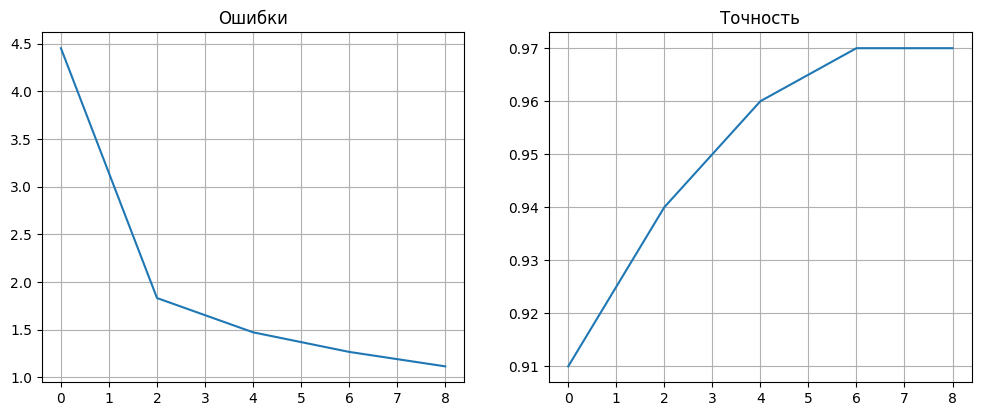

In [21]:
# Построение графиков

graph_batch = plt.figure(figsize=(12, 10), constrained_layout=False)

error_range = np.linspace(0.15, 0)

subgraph_batch_1 = graph_batch.add_subplot(221)
subgraph_batch_1.plot(array_iteration_batch, array_error_batch)
subgraph_batch_1.set_title('Ошибки')
plt.grid()

subgraph_batch_2 = graph_batch.add_subplot(222)
subgraph_batch_2.plot(array_iteration_batch, array_accuracy_batch)
subgraph_batch_2.set_title('Точность')
plt.grid()

In [22]:
# Стохастический градиентный спуск

np.random.seed(1)

learning_rate = 0.005
hidden_size = 40
input_size = 784
num_labels = 10

weights_input_hidden = (2*np.random.random((input_size,hidden_size)) - 1) / np.sqrt(input_size) # веса между входным и скрытым слоями
weights_hidden_output = (2*np.random.random((hidden_size, num_labels)) - 1) / np.sqrt(hidden_size) # веса между скрытым и выходным слоями

array_iteration = []
array_error = []
array_accuracy = []

for iteration in range(6):
   error = 0
   for i in range(len(X_train)):
     # прямой проход
     input_layer = X_train[i:i+1]
     hidden_layer = relu(np.dot(input_layer,weights_input_hidden))
     output_layer = np.dot(hidden_layer,weights_hidden_output)

     error = error + np.sum((output_layer - y_train[i:i+1]) ** 2)

     # обратный проход
     diff_between_output_hidden = 2*(output_layer - y_train[i:i+1])
     weight_hidden_output_corrections = hidden_layer.T.dot(diff_between_output_hidden) # величина коррекции для весов между layer_1 и layer_2

     diff_between_input_hidden = diff_between_output_hidden.dot(weights_hidden_output.T)*relu_two_deriv(hidden_layer)
     weight_input_hidden_corrections = input_layer.T.dot(diff_between_input_hidden)

     weights_hidden_output = weights_hidden_output - learning_rate * weight_hidden_output_corrections
     weights_input_hidden = weights_input_hidden - learning_rate * weight_input_hidden_corrections

   if(iteration % 2 == 0):
      print("Error:", str(error))
      array_iteration.append(iteration)
      array_error.append(error)
      goal_idx = np.argmax(y_train[:100], axis=1)
      y_prediction = model_prediction(X_train[:100], weights_input_hidden, weights_hidden_output)
      pred_idx = np.argmax(y_prediction, axis=1)
      accuracy = accuracy_score(goal_idx ,pred_idx)
      array_accuracy.append(accuracy)
      print("Acc:", str(accuracy))

Error: 1291.235466028888
Acc: 0.91
Error: 622.63734489994
Acc: 0.94
Error: 495.1526135955993
Acc: 0.95


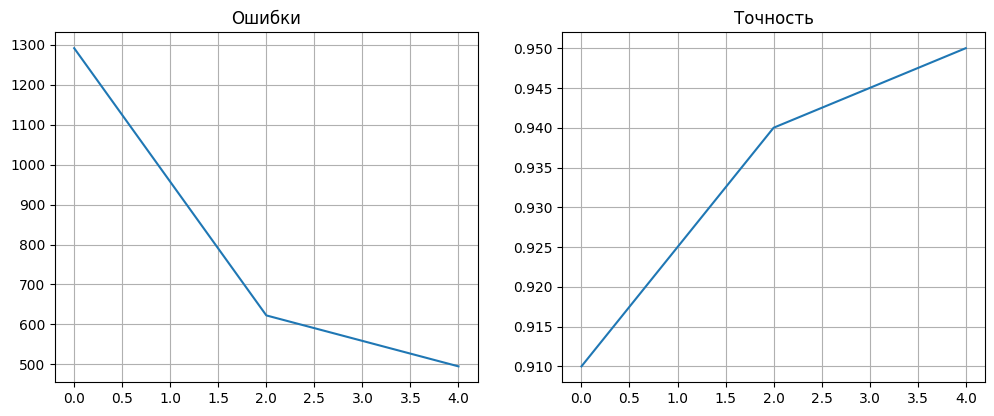

In [23]:
# Построение графиков

graph = plt.figure(figsize=(12, 10), constrained_layout=False)

error_range = np.linspace(0.18, 0)

subgraph_1 = graph.add_subplot(221)
subgraph_1.plot(array_iteration, array_error)
subgraph_1.set_title('Ошибки')
plt.grid()

subgraph_2 = graph.add_subplot(222)
subgraph_2.plot(array_iteration, array_accuracy)
subgraph_2.set_title('Точность')
plt.grid()

In [24]:
# Предсказание
goal_idx = np.argmax(y_test, axis=1)
y_pred = model_prediction(X_test, weights_input_hidden_batch, weights_hidden_output_batch)
pred_idx = np.argmax(y_pred, axis=1)
acc = accuracy_score(goal_idx ,pred_idx)
array_accuracy_batch.append(acc)
print("Test Acc:", acc)

Test Acc: 0.8983333333333333


## 2. Сравнить результаты с использованием однослойного перцептрона из sklearn

In [25]:
# Импорт однослойного перцептрона и его портроение
from sklearn.linear_model import Perceptron

y_train = data_train['label']
y_test = data_test['label']

model = Perceptron(random_state=51)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.835


## 3. Сравнить результаты с использованием многослойного перцептрона из sklearn

In [26]:
# Импорт многослойного перцептрона и его портроение
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=51)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9183333333333333
